<a href="https://colab.research.google.com/github/devangi2000/TensorFlow01/blob/master/S%2BP_W4_C4_LSTM_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [5]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(series, window_size=window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,padding='causal', activation='relu', input_shape=[None,1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 1s 76ms/step - loss: 85.9939 - mae: 86.4934 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 1s 72ms/step - loss: 84.5566 - mae: 85.0559 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 73ms/step - loss: 82.4556 - mae: 82.9550 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 1s 71ms/step - loss: 79.9509 - mae: 80.4501 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 1s 68ms/step - loss: 77.1268 - mae: 77.6261 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 68ms/step - loss: 73.9418 - mae: 74.4410 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 1s 70ms/step - loss: 70.4064 - mae: 70.9056 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 1s 70ms/step - loss: 66.4110 - mae: 66.9099 - lr: 2.2387e-08
Epoch 9/100
12/12 [==============================] - 1s 68ms/step - loss: 61.8734 - mae:

(1e-08, 0.0001, 0.0, 30.0)

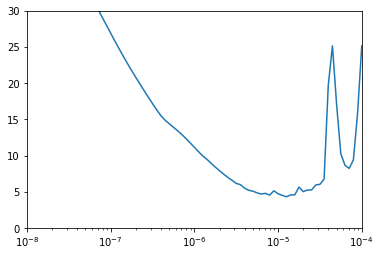

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 1s 27ms/step - loss: 20.0714 - mae: 20.5646
Epoch 2/500
31/31 [==============================] - 1s 27ms/step - loss: 7.9198 - mae: 8.4048
Epoch 3/500
31/31 [==============================] - 1s 29ms/step - loss: 6.6716 - mae: 7.1533
Epoch 4/500
31/31 [==============================] - 1s 28ms/step - loss: 6.1672 - mae: 6.6477
Epoch 5/500
31/31 [==============================] - 1s 28ms/step - loss: 5.7152 - mae: 6.1947
Epoch 6/500
31/31 [==============================] - 1s 28ms/step - loss: 5.6691 - mae: 6.1493
Epoch 7/500
31/31 [==============================] - 1s 28ms/step - loss: 5.5057 - mae: 5.9846
Epoch 8/500
31/31 [==============================] - 1s 28ms/step - loss: 5.4893 - mae: 5.9692
Epoch 9/500
31/31 [==============================] - 1s 29ms/step - loss: 5.5435 - mae: 6.0236
Epoch 10/500
31/31 [==============================] - 1s 29ms/step - loss: 5.2388 - mae: 5.7178
Epoch 11/500
31/31 [===========================

In [19]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

ValueError: ignored

ValueError: ignored

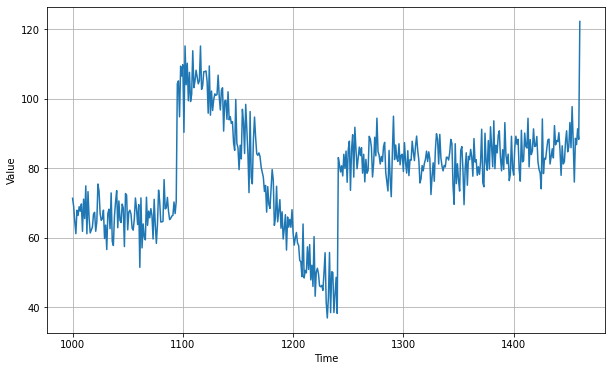

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
tf.keras.metrics.mean_squared_error(x_valid, rnn_forecast).numpy()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

loss = history.history['loss']
mae = history.history['mae']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r')
plt.plot(epochs,mae, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()

epochs_zoom = epochs[200:]
loss_zoom = loss[200:]
mae_zoom = mae[200:]

plt.plot(epochs_zoom, loss_zoom, 'r')
plt.plot(epochs_zoom, mae_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])
plt.figure()